In [167]:
import os
import torch
import fastai
import azureml
import azureml.core
from azureml.core import Dataset, Run, Datastore, Workspace
import pandas as pd
import numpy as np
from diff_classifier import features
import matplotlib.pyplot as plt

In [9]:
# for local debugging
subscription_id = '9c49afdd-cccb-44e2-a4eb-5b2f941c774c'
resource_group = 'schimek_cloud'
workspace_name = 'nels_east_us'

workspace = azureml.core.Workspace(subscription_id, resource_group, workspace_name)

In [10]:
datastore = Datastore.get(workspace, 'workspaceblobstore')
file_dataset = Dataset.File.from_files(path=(datastore, 'UI/2023-04-21_000140_UTC/'))

In [11]:
dataset = file_dataset.register(workspace = workspace, name = 'mpt_training_data', create_new_version=True)

In [12]:
dataset = Dataset.get_by_name(workspace, name='mpt_training_data')
dataset.download(target_path='.', overwrite=True)

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/nlsschim1/code/Users/nlsschim/practical_deep_learning_for_coders/notebooks/msd_P14_40nm_s1_v1.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nlsschim1/code/Users/nlsschim/practical_deep_learning_for_coders/notebooks/msd_P14_40nm_s1_v2.csv',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/nlsschim1/code/Users/nlsschim/practical_deep_learning_for_coders/notebooks/msd_P14_40nm_s1_v3.csv']

In [18]:
df_1 = pd.read_csv('msd_p14_40nm_s1_v1.csv')
df_1.head()

,Unnamed: 0,Frame,Track_ID,X,Y,MSDs,Gauss,Quality,SN_Ratio,Mean_Intensity
0,0,0.0,0.0,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,1,1.0,0.0,NaN,NaN,221.940562,0.945131,NaN,NaN,NaN
2,2,2.0,0.0,NaN,NaN,395.453323,0.604359,NaN,NaN,NaN
3,3,3.0,0.0,NaN,NaN,530.226501,0.588696,NaN,NaN,NaN
4,4,4.0,0.0,NaN,NaN,627.000852,0.457320,NaN,NaN,NaN


In [173]:
def make_new_dataset(csv, track_id_col, output_dir):

    labels = {}
    track_ids = []
    file_name = csv
    df = pd.read_csv(csv)
    for track_id in df[track_id_col].unique():
        label = file_name[:-4] + f'_track_{int(track_id)}.npy'
        comp_track = features.unmask_track(df[df['Track_ID']==track_id])
        if len(comp_track['X']) >= 10:
            alpha, dcoef = features.alpha_calc(comp_track)
            if dcoef > 0 and dcoef < 20:
                track_data = comp_track[['X', 'Y']]
                labels[str(label)] = dcoef
                track_ids.append(str(label))
                test_array = np.array(track_data)
                new_shape = (651, 2)
                pad_width = [(0, new_shape[i] - test_array.shape[i]) for i in range(len(new_shape))]
                out_array = np.pad(test_array, pad_width, mode='constant')
                #np.save(output_dir + str(label), out_array)
    labels = pd.DataFrame.from_dict(labels, orient='index', columns=['dcoef'])
    return labels


In [174]:
labels = make_new_dataset('msd_p14_40nm_s1_v1.csv', 'Track_ID', 'training_data/')

In [175]:
labels.to_csv('training_data/labels.csv')

In [176]:
traj_labels = pd.read_csv('training_data/labels.csv')
print(traj_labels.iloc[0, 0])
print(traj_labels.iloc[0, 1])

msd_p14_40nm_s1_v1_track_1.npy
1.6117280148626445


In [177]:
class MptDataset(Dataset):
    def __init__(self, annotations_file, traj_dir, transform=None, target_transform=None):
        self.traj_labels = pd.read_csv(annotations_file)
        self.traj_dir = traj_dir
        self.transform = transform # for future use maybe?
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.traj_labels)
    
    def __getitem__(self, idx):
        traj_path = os.path.join(self.traj_dir, self.traj_labels.iloc[idx, 0])
        traj = np.load(traj_path)
        label = self.traj_labels.iloc[idx, 1]
       
        return traj, label

In [179]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(MptDataset('training_data/labels.csv', 'training_data/'), batch_size=64, shuffle=True, num_workers=4)

In [180]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 651, 2])
Labels batch shape: torch.Size([64])


(array([14.,  6.,  8.,  1.,  5.,  7.,  5.,  4.,  8.,  6.]),
 array([7.44710107e-07, 1.94879044e+00, 3.89758013e+00, 5.84636982e+00,
        7.79515951e+00, 9.74394920e+00, 1.16927389e+01, 1.36415286e+01,
        1.55903183e+01, 1.75391080e+01, 1.94878977e+01]),
 <BarContainer object of 10 artists>)

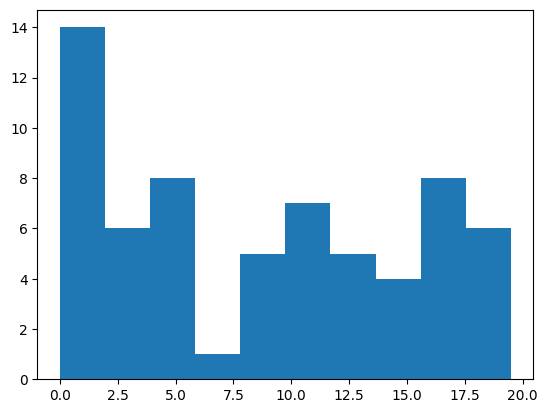

In [181]:
plt.hist(train_labels)

In [187]:
import torch
import torch.nn as nn
import torch.optim as optim

batch_size = 8
T = [50, 51]
steps = 1000
initializer = nn.init.kaiming_normal_
f = 32
sigma = 0.1

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv1d(2, f, kernel_size=2, padding=1)
        self.bn1 = nn.BatchNorm1d(f)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(f, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.double() # convert input tensor to double precision
        x = x.permute(0, 2, 1) # transpose input tensor to shape (batch_size, num_channels, seq_length)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, f)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

model = MyModel()

optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()

print(model)


MyModel(
  (conv1): Conv1d(2, 32, kernel_size=(2,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=32, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [188]:
num_epochs = 100
model = model.double() # convert model to double precision

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = inputs.double() # convert inputs to double precision
        labels = labels.double() # convert labels to double precision
        
        optimizer.zero_grad()
        
        outputs = model(inputs)

           # Reshape the target tensor if necessary
        if labels.shape != outputs.shape:
            labels = labels.view(-1, 1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    import torch.nn.functional as F

    # Set the model to evaluation mode
    model.eval()

    # Calculate the MSE for the validation set
    val_loss = 0
    for inputs, labels in train_dataloader:
        inputs = inputs.double() # convert inputs to double precision
        labels = labels.double() # convert labels to double precision
        
        outputs = model(inputs)

        # Reshape the target tensor if necessary
        if labels.shape != outputs.shape:
            labels = labels.view(-1, 1)
        loss = F.mse_loss(outputs, labels)
        val_loss += loss.item()

    # Calculate the average MSE for the validation set
    avg_val_loss = val_loss / len(train_dataloader)
    print("Validation MSE: ", avg_val_loss)


Validation MSE:  85.96506982708367
Validation MSE:  87.95207896397748
Validation MSE:  78.85719818566828
Validation MSE:  82.6691163122269
Validation MSE:  86.5439929280589
Validation MSE:  75.72652240371552
Validation MSE:  79.86037870453869
Validation MSE:  84.92673266116365
Validation MSE:  82.33811533756857
Validation MSE:  87.67294022459212
Validation MSE:  75.9464778895719
Validation MSE:  75.58248238023815
Validation MSE:  76.21505287109056
Validation MSE:  82.72805426497948
Validation MSE:  78.62132392016582
Validation MSE:  88.52145274411497
Validation MSE:  85.53799822985188
Validation MSE:  81.01623624959133
Validation MSE:  85.85235280305955
Validation MSE:  85.86733935394682
Validation MSE:  81.49779215490237
Validation MSE:  81.29868251661412
Validation MSE:  90.69033956870665
Validation MSE:  74.85567532291583
Validation MSE:  86.88352931322827
Validation MSE:  82.67492520950235
Validation MSE:  77.71093941578333
Validation MSE:  86.84041418011185
Validation MSE:  82.936

In [183]:
# Set the model to evaluation mode
model.eval()

# Create lists to store predictions and true labels
preds = []
targets = []

# Predict on the test set and store predictions and true labels
for inputs, labels in train_dataloader:
    inputs = inputs.double()
    labels = labels.double()
    with torch.no_grad():
        outputs = model(inputs)
    # Reshape the target tensor if necessary
    if labels.shape != outputs.shape:
        labels = labels.view(-1, 1)
    preds.extend(outputs.tolist())
    targets.extend(labels.tolist())

# Convert the predictions and targets to numpy arrays
preds = np.array(preds)
targets = np.array(targets)

# Print the predictions and targets
print("Predictions: ", preds)
print("Targets: ", targets)

Predictions:  [[1.        ]
 [1.        ]
 [0.99999999]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.99999975]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.99999989]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.99999396]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.99999993]
 [0.99999996]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.99999893]
 [1.  

In [147]:
num_epochs = 10

for epoch in range(num_epochs):
    # training loop
    for i, (inputs, targets) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # validation loop
    with torch.no_grad():
        total_loss = 0
        for j, (inputs, targets) in enumerate(train_dataloader):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
        val_loss = total_loss / len(train_dataloader)
        
    print(f"Epoch {epoch+1} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss:.4f}")

RuntimeError: expected scalar type Double but found Float